# Convolutional Networks


## Convolutional Architectures
When modelling an image using a regular feed-forward network, the number of parameters quickly gets huge. You will see this if you calculated how many parameters there are in a feed-forward network with 2 hidden layers consisting of say, 200 neurons each, an output size of 10 and an input image of shape [32, 32, 3]? (Note that we represent each pixel in a a colour image using three real-numbers for the Red, Green and Blue values and hence the 32x32**x3** shape.)

ConvNets address this model parameter issue by exploiting structure in the inputs to the network (in particular, by making the assumption that the input is a 3-D *volume*, which applies to images for example, where the 3 dimensions consist of the three RGB channels). The two key differences between a ConvNet and a Feed-forward network are:

* ConvNets have neurons that are arranged in 3 dimensions: width, height, depth. Note that *depth* here means channels, i.e. the depth of the input volume, not the depth of a deep neural network!
* The neurons in each layer are only connected to a small region of the layer before it.



## The CIFAR10 Dataset
We will combine what we've learned about convolution, max-pooling and feed-forward layers, to build a ConvNet classifier for images. 

First we import relevant packages (install them if needed) and initialise some variables.

In [1]:
from __future__ import absolute_import, division, print_function

# Prerequisits
!pip install pydot_ng
!pip install graphviz
!apt install graphviz > /dev/null

# import statements
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

You should consider upgrading via the 'c:\users\pewn\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\pewn\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.
The system cannot find the path specified.


We will use the colour image dataset CIFAR10 (pronounced "seefar ten") which consists of 50,000 training images and 10,000 test images. We will take 10,000 images from the training set to form a validation set.

In [2]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Take the last 10000 images from the training set to form a validation set 
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

In [4]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


Run the below cell to see random images taken from the Dataset

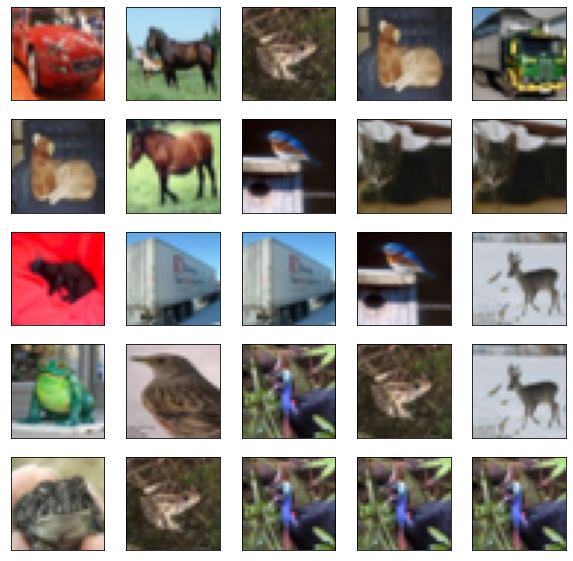

In [5]:
import random as rd

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(train_images[rd.randint(i,25)])


### Building a CNN

Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers have on the number of parameters, we'll build the model in two stages. 

First, the convolutional layers + max-pooling:

The hyper-parameters of a convolutional layer are as follows:
* **Filters** defines the number of filters in the layer. The filters are what is convolved over the input to recognise patterns. 
* **Kernel Size** defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
* **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.



In [6]:
# Define the convolutinal part of the model architecture using Keras Layers.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])

How many parameters are there in the convolutional part of the architecture? We can easily inspect this using the model summary function in Keras:

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 48)        1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 128)       55424     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 192)         221376    
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 192)         3

Now we add a fully-connected part. Note that we also add "Dropout" after the first fully-connected layer. Dropout is a regularisation technique which randomly zeros out ("drops") connections between neurons, and it was one of the key innovations of the AlexNet paper in 2012. Dropout is effective because it combats overfitting: random dropping of neurons forces the network to learn robust, general patterns, rather than model every peculiarity of the training data.

In [8]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 48)        1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 128)       55424     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 192)         221376    
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 192)         3

####Aside: Random initialisation schemes

You might have wondered what values we are using for the initial values of the weights and biases in our model. The short answer is that we typically use random initialisation. In this case, we have just been using the default keras initialisers for each layer, which are usually sufficient.

The longer answer is that just using completely random numbers does not always work best in practice and that there are a number of common initialisation schemes (which are available in most deep learning frameworks such as TensorFlow and Keras).

Lets consider a few examples:

 * When using the ReLU activation it is common to initialise the biases with small positive numbers (like the vector of 1s in the previous Task's compulsory exercise). This encourages the ReLU activations to start off in the _on_ state, which helps to counteract the _dying ReLU problem_. ReLU neurons "die" when a configuration of weights is such that that neuron only receive negative inputs, in which case it will always output zero and cannot contribute to the learning anymore.

 * The deeper neural networks become the more numbers are multiplied together. There is therefore a risk that gradients become smaller and smaller, in which case the network stops learning, or get bigger and bigger, in which case the network become imprecises. This shrink to the point that they vanish, or grow to the point that they overflow are called the _vanishing_ and _exploding_ gradient problems. To help combat this we can initialise our weights to have a (model-specific) appropriate scale. One method for doing this is called [_Xavier_ or _Glorot_](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialisation.

 * The _Xavier_ initialisation scheme was designed with the _traditional_ activations Sigmoid and TanH in mind, and does not work as well for ReLU activations. An alternative is [_He_](https://arxiv.org/pdf/1502.01852.pdf) initialisation which is a modification of _Xavier_ initialisation for ReLU activations.

 [This blog](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) goes into more detail on _He_ and _Xavier_ initialisation. [The Keras documentation](https://keras.io/initializers/) lists a number of common schemes. 

### Visualising the model

Let's build a flow-diagram of the model we've constructed to see how information flows between the different layers.

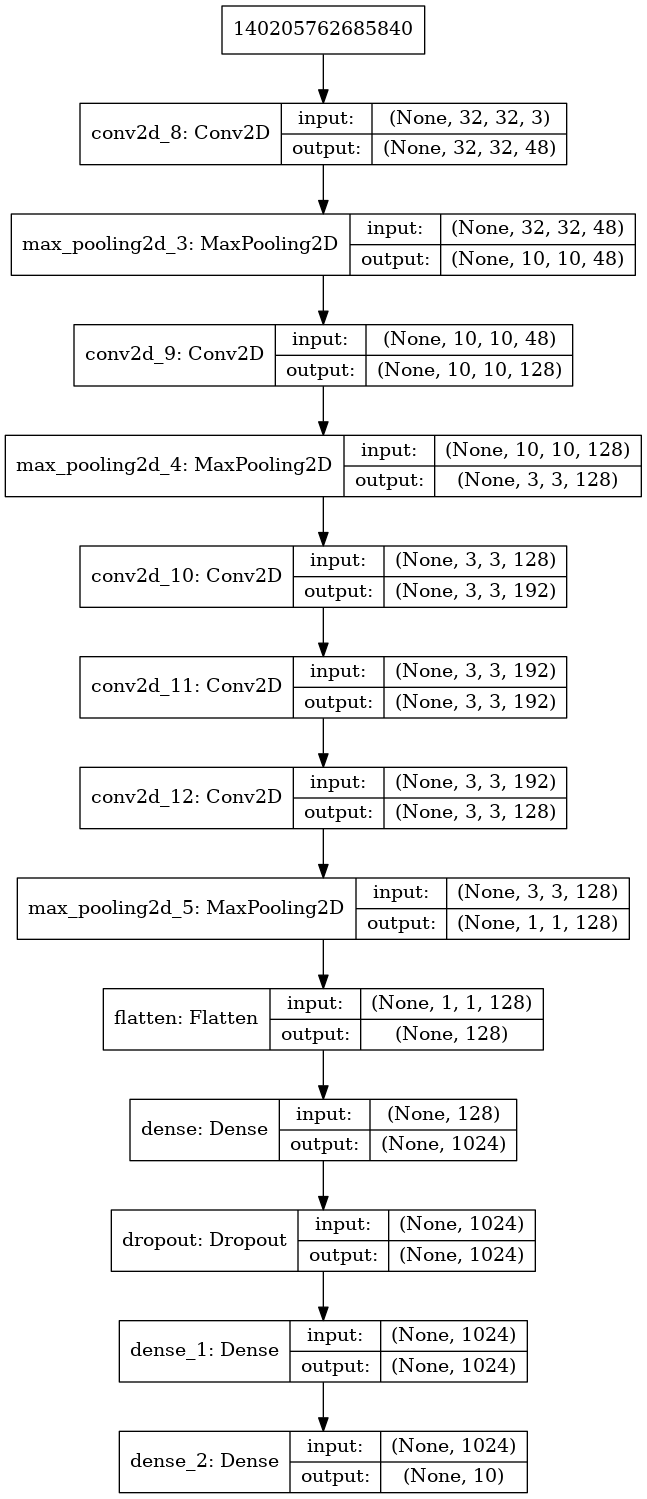

In [0]:
tf.keras.utils.plot_model(model, to_file='small_lenet.png', show_shapes=True, show_layer_names=True)
display.display(display.Image('small_lenet.png'))

### Training and Validating the model
In the last practical we had you write out the training-loop to give you a good appreciation for how it works. This time, we use the fitting method built-in to Keras. For simple, standard datasets like CIFAR, doing it this way will work fine, but it's important to know what goes on under the hood because you may need to write some or all of the steps out manually when working with more complex datasets! 

In [10]:
batch_size = 128
num_epochs = 10  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=keras.optimizers.Adadelta(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
model.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Epoch 1/10
313/313 [==============================] - 28s 88ms/step - loss: 3.2897 - accuracy: 0.1036 - val_loss: 2.2896 - val_accuracy: 0.1374
Epoch 2/10
313/313 [==============================] - 27s 85ms/step - loss: 2.5697 - accuracy: 0.1199 - val_loss: 2.2039 - val_accuracy: 0.1933
Epoch 3/10
313/313 [==============================] - 26s 82ms/step - loss: 2.3744 - accuracy: 0.1431 - val_loss: 2.1443 - val_accuracy: 0.2473
Epoch 4/10
313/313 [==============================] - 26s 84ms/step - loss: 2.2743 - accuracy: 0.1676 - val_loss: 2.0910 - val_accuracy: 0.2793
Epoch 5/10
313/313 [==============================] - 26s 82ms/step - loss: 2.2033 - accuracy: 0.1920 - val_loss: 2.0398 - val_accuracy: 0.2944
Epoch 6/10
313/313 [==============================] - 27s 85ms/step - loss: 2.1480 - accuracy: 0.2129 - val_loss: 1.9922 - val_accuracy: 0.3120
Epoch 7/10
313/313 [==============================] - 26s 84ms/step - loss: 2.0926 - accuracy: 0.2292 - val_loss: 1.9509 - val_accuracy:

### Test performance
Finally, we evaluate how well the model does on the held-out test-set

In [12]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

313/313 [==============================] - 3s 8ms/step - loss: 1.8723 - accuracy: 0.3336
Final TEST performance
loss: 1.8722810745239258
accuracy: 0.3336000144481659


### Classifying examples
We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side. 

In [31]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

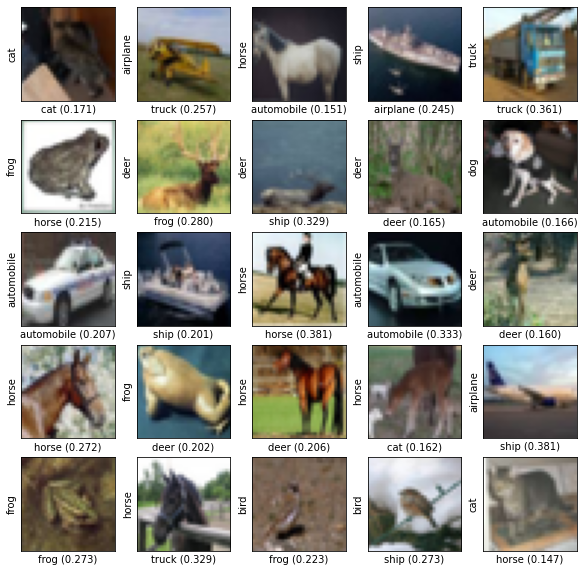

In [32]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))
  

### Aside: Uncertainty in deep learning

Deep neural networks are not considered to be very good at estimating the uncertainty in their predictions. However, knowing your model's uncertainty can be very important for many applications. For example, consider a deep learning tool for diagnosing diseases, in this case a false negative could have massive impacts on a person's life! We would really like to know how confident our model is in its prediction. This is a budding field of research, for example see [this blog](https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html) for a nice introduction.

### Aside: CNN architectures

Deciding on the architecture for a CNN, i.e. the combination of convolution, pooling, dense, and other layers, can be tricky and often can seem arbitrary. On top of that, one also has to make decisions such as what kind of pooling, which activation functions, and what size of convolution to use, among other things. For new and old practitioners of deep learning, these choices can be overwhelming. 

However, by examining existing successful CNN architectures we can learn a lot about what works and what doesn't. (We can even apply these existing architectures to our problems since many deep learning libraries, such as TensorFlow and Keras, have them [built in](https://keras.io/applications/#available-models) and it is even possible to fine-tune pre-trained models to our specific problem using [transfer learning](https://cs231n.github.io/transfer-learning/).)

[This article](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) describes many of the most successful CNN architectures in recent years, including [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/pdf/1512.00567v3.pdf) and [VGG](https://arxiv.org/pdf/1409.1556.pdf). For a more detailed and technical description of these models and more see [these slides](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture9.pdf). Reading through these resources should give you insights into why these architectures are successful as well as best practices and current trends for CNNs that will help you design your own architectures.




## Your Tasks

1. Experiment with the network architecture, try changing the numbers, types and sizes of layers, the sizes of filters, using different padding etc. How do these decisions affect the performance of the model? In particular, try building a *fully convolutinoal* network, with no (max-)pooling layers. 
2.  Implement BATCH NORMALISATION ([Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) and [research paper](http://proceedings.mlr.press/v37/ioffe15.pdf)) to improve the model's generalisation.

5. Why do modern architectures use less max-pooling?
6. What does a 1x1 convolution do?
7. What is a residual connection?

##Additional Resources for your own time

Here's some more information on ConvNets:

* Chris Colah's blog post on [Understanding Convolutions](https://colah.github.io/posts/2014-07-Understanding-Convolutions/)
* [How do convolutional neural networks work?](http://brohrer.github.io/how_convolutional_neural_networks_work.html)
* The [CS231n course](https://cs231n.github.io/)
* [Building blocks of interpretability](https://distill.pub/2018/building-blocks/)

